Lecture : https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb


In [1]:
!nvidia-smi

Sat Sep 10 06:07:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-09-10 06:07:24--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  65.6MB/s    in 2.4s    

2022-09-10 06:07:27 (65.6 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMAGE_SHAPE = (224,224)
BATCH_SIZE=32
train_dir = "10_food_classes_10_percent/train/"
test_dir="10_food_classes_10_percent/test/"
train_datagen=ImageDataGenerator(rescale=1/255.)
test_datagen=ImageDataGenerator(rescale=1/255.)
print("Training images :")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")
print("Testing images :")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images :
Found 750 images belonging to 10 classes.
Testing images :
Found 2500 images belonging to 10 classes.


In [9]:
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir=dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to :{log_dir}")
  return tensorboard_callback

In [10]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [11]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url= "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [18]:
def create_model(model_url, num_classes = 10):
  feature_extractor_layers=hub.KerasLayer(model_url,
                                          trainable= False,
                                          name="feature_extraction_layer",
                                          input_shape=IMAGE_SHAPE+(3,))
  model=tf.keras.Sequential([
      feature_extractor_layers,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])
  return model

In [19]:
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [20]:
resnet_history=resnet_model.fit(train_data_10_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files)

Saving TensorBoard log files to :tensorflow_hub/resnet50V2/20220910-062616
Epoch 1/5
24/24 [==============================] - 46s 1s/step - loss: 2.0588 - accuracy: 0.3067 - val_loss: 1.3291 - val_accuracy: 0.5584
Epoch 2/5
24/24 [==============================] - 16s 698ms/step - loss: 0.9896 - accuracy: 0.6827 - val_loss: 0.8802 - val_accuracy: 0.7204
Epoch 3/5
24/24 [==============================] - 17s 739ms/step - loss: 0.6601 - accuracy: 0.7987 - val_loss: 0.7568 - val_accuracy: 0.7648
Epoch 4/5
24/24 [==============================] - 17s 732ms/step - loss: 0.5001 - accuracy: 0.8773 - val_loss: 0.7060 - val_accuracy: 0.7776
Epoch 5/5
24/24 [==============================] - 17s 728ms/step - loss: 0.4010 - accuracy: 0.9040 - val_loss: 0.7014 - val_accuracy: 0.7724


In [21]:
import matplotlib.pyplot as plt
def plot_loss_curves(history) : 
  loss=history.history["loss"]
  val_loss=history.history["val_loss"]
  accuracy=history.history["accuracy"]
  val_accuracy=history.history["val_accuracy"]
  epochs=range(len(history.history["loss"]))

  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label= "training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

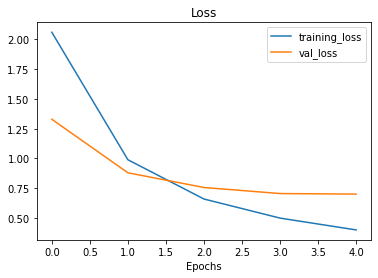

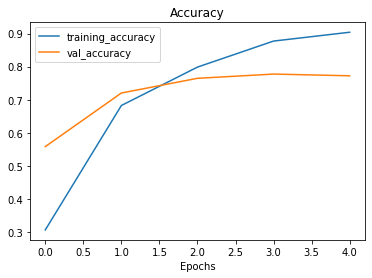

In [22]:
plot_loss_curves(resnet_history)

In [23]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [24]:
efficientnet_model = create_model(model_url=efficientnet_url, 
                                  num_classes=train_data_10_percent.num_classes)
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5, 
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to :tensorflow_hub/efficientnetB0/20220910-063701
Epoch 1/5
24/24 [==============================] - 36s 1s/step - loss: 1.9474 - accuracy: 0.3827 - val_loss: 1.3576 - val_accuracy: 0.6964
Epoch 2/5
24/24 [==============================] - 16s 677ms/step - loss: 1.1035 - accuracy: 0.7480 - val_loss: 0.9002 - val_accuracy: 0.8176
Epoch 3/5
24/24 [==============================] - 16s 695ms/step - loss: 0.7830 - accuracy: 0.8307 - val_loss: 0.7225 - val_accuracy: 0.8368
Epoch 4/5
24/24 [==============================] - 16s 679ms/step - loss: 0.6300 - accuracy: 0.8653 - val_loss: 0.6277 - val_accuracy: 0.8492
Epoch 5/5
24/24 [==============================] - 18s 768ms/step - loss: 0.5299 - accuracy: 0.8827 - val_loss: 0.5714 - val_accuracy: 0.8572


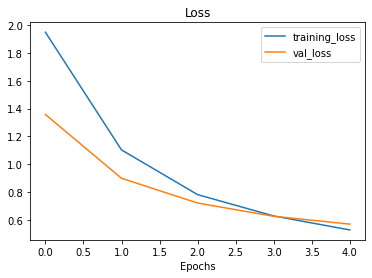

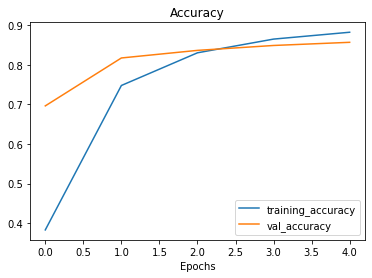

In [25]:
plot_loss_curves(efficientnet_history)

In [26]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


TensorBoard

In [28]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
--name "EfficientNetB0 vs. ResNet50V2" \
--description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
--one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=FQmdHFVCQKEuQolqv4a4fOj5qb04x2&prompt=consent&access_type=off

In [29]:
! tensorboard dev list

https://tensorboard.dev/experiment/nK72vcGsQAWdN2WiguDENA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   nK72vcGsQAWdN2WiguDENA
	Created              2022-09-10 06:44:04 (18 seconds ago)
	Updated              2022-09-10 06:44:10 (12 seconds ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5918783
Total: 1 experiment(s)


In [30]:
!tensorboard dev delete --experiment_id 

usage: tensorboard dev delete [-h] [--helpfull]
                              [--experiment_id EXPERIMENT_ID]
tensorboard dev delete: error: argument --experiment_id: expected one argument


In [31]:
!tensorboard dev list

https://tensorboard.dev/experiment/nK72vcGsQAWdN2WiguDENA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   nK72vcGsQAWdN2WiguDENA
	Created              2022-09-10 06:44:04 (34 seconds ago)
	Updated              2022-09-10 06:44:10 (28 seconds ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5918783
Total: 1 experiment(s)
